In [1]:
import torch
from torch import Tensor
from torch import nn 
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
from utility import *

np.random.seed(seed=7)

In [2]:
import dlc_bci

train_input_100 , train_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False)
test_input_100 , test_target_100 = dlc_bci.load(root = './data_bci_100Hz', download = False, train = False)

train_input_1000 , train_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, one_khz = True)
test_input_1000 , test_target_1000 = dlc_bci.load(root = './data_bci_1000Hz', download = False, train = False, one_khz = True)

print("Train input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_100.size())))
print("Train target 100 Hz: {:d}".format(*(s for s in train_target_100.size())))
print("Test input 100 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_100.size())))
print("Test target 100 Hz: {:d}".format(*(s for s in test_target_100.size())))
print("")
print("Train input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in train_input_1000.size())))
print("Train target 1000 Hz: {:d}".format(*(s for s in train_target_1000.size())))
print("Test input 1000 Hz: {:d}x{:d}x{:d}".format(*(s for s in test_input_1000.size())))
print("Test target 1000 Hz: {:d}".format(*(s for s in test_target_1000.size())))

Train input 100 Hz: 316x28x50
Train target 100 Hz: 316
Test input 100 Hz: 100x28x50
Test target 100 Hz: 100

Train input 1000 Hz: 316x28x500
Train target 1000 Hz: 316
Test input 1000 Hz: 100x28x500
Test target 1000 Hz: 100


# Network definition

This conv2d network is more inspired from a classic conv2d net that is used for image recognition 

In [3]:
from models import *

# Preprocessing and Data Augmentation

In [4]:
import numpy as np

preprocessed_input_train, preprocessed_input_validation, preprocessed_input_train_target, preprocessed_input_validation_target, kept_channels_idx = preprocessing_train(train_input_1000, train_target_1000, subsampling_frequency='100Hz', window=False,denoize=False, addGaussianNoise=False, reduceChannels=False, cutEnd = False)
preprocessed_input_test, preprocessed_input_test_target  = preprocessing_test(test_input_1000, test_target_1000, kept_channels_idx, subsampling_frequency='100Hz', window=False,denoize = False, reduceChannels=False, cutEnd=False)

#Remove Noise
#preprocessed_input_train = denoisedSignals(preprocessed_input_train)
#preprocessed_input_validation = denoisedSignals(preprocessed_input_validation)
#preprocessed_input_test = denoisedSignals(preprocessed_input_test)
#add random noise
#preprocessed_input_train = whiteNoise(preprocessed_input_train)
#preprocessed_input_validation = whiteNoise(preprocessed_input_validation)
#preprocessed_input_test = whiteNoise(preprocessed_input_test)

print('train', preprocessed_input_train.shape)
print('test', preprocessed_input_test.shape)
print('validation', preprocessed_input_validation.shape)

labels_train = torch.from_numpy(preprocessed_input_train_target)
labels_test = torch.from_numpy(preprocessed_input_test_target)
labels_validation = torch.from_numpy(preprocessed_input_validation_target)

preprocessed_input_train = torch.from_numpy(preprocessed_input_train).float()
preprocessed_input_test = torch.from_numpy(preprocessed_input_test).float()
preprocessed_input_validation = torch.from_numpy(preprocessed_input_validation).float()

Ntrain = len(preprocessed_input_train[:,0,0])
Ntest = len(preprocessed_input_test[:,0,0])
Nvalidation = len(preprocessed_input_validation[:,0,0])

Nchannels = len(preprocessed_input_train[0,:,0])
Nsamples_100 = preprocessed_input_train.size(-1)

print('Ntrain = ', Ntrain)
print('Ntest = ', Ntest)
print('Nvalidation = ', Nvalidation)

train_input = Variable(preprocessed_input_train.view(Ntrain, 1, Nchannels, Nsamples_100))
validation_input = Variable(preprocessed_input_validation.view(Nvalidation, 1, Nchannels, Nsamples_100), requires_grad=False)
test_input = Variable(preprocessed_input_test.contiguous().view(Ntest, 1, Nchannels, Nsamples_100), requires_grad=False)

train (3000, 28, 50)
test (1000, 28, 50)
validation (160, 28, 50)
Ntrain =  3000
Ntest =  1000
Nvalidation =  160


# Network training and testing

In [5]:
import torch.optim as optim
import math

# Train network 
criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
#criterion = nn.PoissonNLLLoss()
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.SmoothL1Loss() #interesting ... but does not converge
#criterion = nn.MSELoss() #0.83 but unstable

if isinstance(criterion, nn.CrossEntropyLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False)
    Noutputs = 2
    
elif isinstance(criterion, nn.NLLLoss):
    train_target = Variable(labels_train)  # keep long tensors
    validation_target = Variable(labels_validation, requires_grad=False) # convert to float
    test_target = Variable(labels_test, requires_grad=False )
    Noutputs = 2
    
else:
    train_target = Variable(labels_train.float()) # convert to float
    validation_target = Variable(labels_validation.float(), requires_grad=False) # convert to float
    test_target = Variable(labels_test.float(), requires_grad=False)
    Noutputs = 1

batch_size = 5
Nbatches = int(math.ceil(Ntrain/batch_size))
Nepochs = 50
seeds = list(range(10))
#seeds = [14,20,21,22,27,46,44,37,31,28]
Nrep = len(seeds)

train_errors = torch.Tensor(Nrep, Nepochs).zero_()
test_errors = torch.Tensor(Nrep, Nepochs).zero_()
validation_errors = torch.Tensor(Nrep, Nepochs).zero_()
ep_loss = torch.Tensor(Nrep, Nepochs).zero_()

for i_rep in range(Nrep):
    
    print('Repetition', seeds[i_rep])
    torch.manual_seed(seeds[i_rep])
    #model = conv2DNet_1(Noutputs) #from classic knowledge of image segmentation  
    #model = conv2DNet_2(Nchannels, Nsamples_100, Noutputs) #from litterature 
    #model = conv2DNet_3(Noutputs) #from PdM
    #model = conv2DNet_4(Noutputs) #from PdM
    #model = conv2DNet_5(Noutputs)
    #model = conv2DNet_6(Noutputs)
    #model = conv2DNet_7(Noutputs)
    model = conv2DNet_9(Noutputs)
    
    #optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.50)
    optimizer = optim.Adam(model.parameters())
    #optimizer = optim.Adagrad(model.parameters())
    #optimizer = optim.Adamax(model.parameters())
    #optimizer = optim.ASGD(model.parameters())
    #optimizer = optim.RMSprop(model.parameters())
    #optimizer = optim.Rprop(model.parameters())
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)

    for i_ep in range(Nepochs):
        for b_start in range(0, Ntrain, batch_size):
            bsize_eff = batch_size - max(0, b_start+batch_size-Ntrain)  # boundary case
            model.train()
            model.zero_grad()
            output = model.forward(train_input.narrow(0, b_start, bsize_eff))
            batch_loss = criterion(output.view(bsize_eff), train_target.narrow(0, b_start, bsize_eff))            
            ep_loss[i_rep, i_ep] += batch_loss.data[0]
            batch_loss.backward()
            optimizer.step()
        
        scheduler.step(ep_loss[i_rep, i_ep])
        
        nb_train_errs = compute_nb_errors(model, train_input, train_target, batch_size, criterion)
        nb_validation_errs = compute_nb_errors(model, validation_input, validation_target, batch_size, criterion)
        nb_test_errs = compute_nb_errors(model, test_input, test_target, batch_size, criterion)
        
        print("Epoch Number : ", i_ep)
        print("\t Training accuracy: ", (100*(Ntrain-nb_train_errs)/Ntrain))
        print("\t Validation accuracy ",(100*(Nvalidation-nb_validation_errs)/Nvalidation)) 
        print("\t Test accuracy ",(100*(Ntest-nb_test_errs)/Ntest))
        
        print("\t Epoch Loss ", ep_loss[i_rep, i_ep])
        
        train_errors[i_rep, i_ep] = nb_train_errs
        test_errors[i_rep, i_ep] = nb_test_errs
        validation_errors[i_rep, i_ep] = nb_validation_errs

Repetition 0
Epoch Number :  0
	 Training accuracy:  71.16666666666667
	 Validation accuracy  63.125
	 Test accuracy  59.5
	 Epoch Loss  404.9491271972656
Epoch Number :  1
	 Training accuracy:  83.43333333333334
	 Validation accuracy  83.75
	 Test accuracy  79.7
	 Epoch Loss  338.5991516113281
Epoch Number :  2
	 Training accuracy:  85.4
	 Validation accuracy  80.0
	 Test accuracy  79.1
	 Epoch Loss  289.02001953125
Epoch Number :  3
	 Training accuracy:  88.03333333333333
	 Validation accuracy  78.125
	 Test accuracy  81.0
	 Epoch Loss  243.5587158203125
Epoch Number :  4
	 Training accuracy:  92.06666666666666
	 Validation accuracy  83.125
	 Test accuracy  77.7
	 Epoch Loss  229.65191650390625
Epoch Number :  5
	 Training accuracy:  93.53333333333333
	 Validation accuracy  79.375
	 Test accuracy  80.2
	 Epoch Loss  221.8732147216797
Epoch Number :  6
	 Training accuracy:  88.6
	 Validation accuracy  77.5
	 Test accuracy  79.1
	 Epoch Loss  189.59884643554688
Epoch Number :  7
	 Trai

Epoch Number :  9
	 Training accuracy:  95.43333333333334
	 Validation accuracy  80.0
	 Test accuracy  79.0
	 Epoch Loss  162.782470703125
Epoch Number :  10
	 Training accuracy:  94.16666666666667
	 Validation accuracy  85.625
	 Test accuracy  79.4
	 Epoch Loss  166.8719482421875
Epoch Number :  11
	 Training accuracy:  94.16666666666667
	 Validation accuracy  83.75
	 Test accuracy  79.5
	 Epoch Loss  149.9258575439453
Epoch Number :  12
	 Training accuracy:  94.0
	 Validation accuracy  81.875
	 Test accuracy  80.0
	 Epoch Loss  170.7324981689453
Epoch Number :  13
	 Training accuracy:  96.0
	 Validation accuracy  73.75
	 Test accuracy  78.9
	 Epoch Loss  152.74948120117188
Epoch Number :  14
	 Training accuracy:  95.86666666666666
	 Validation accuracy  75.0
	 Test accuracy  79.9
	 Epoch Loss  148.03768920898438
Epoch Number :  15
	 Training accuracy:  96.23333333333333
	 Validation accuracy  79.375
	 Test accuracy  80.2
	 Epoch Loss  150.84100341796875
Epoch Number :  16
	 Training 

Epoch Number :  19
	 Training accuracy:  95.86666666666666
	 Validation accuracy  81.25
	 Test accuracy  76.9
	 Epoch Loss  136.44635009765625
Epoch Number :  20
	 Training accuracy:  96.83333333333333
	 Validation accuracy  85.625
	 Test accuracy  78.8
	 Epoch Loss  137.24815368652344
Epoch Number :  21
	 Training accuracy:  96.7
	 Validation accuracy  85.0
	 Test accuracy  80.5
	 Epoch Loss  129.18540954589844
Epoch Number :  22
	 Training accuracy:  97.56666666666666
	 Validation accuracy  85.0
	 Test accuracy  79.0
	 Epoch Loss  145.8143310546875
Epoch Number :  23
	 Training accuracy:  97.23333333333333
	 Validation accuracy  83.125
	 Test accuracy  80.3
	 Epoch Loss  134.06039428710938
Epoch Number :  24
	 Training accuracy:  97.83333333333333
	 Validation accuracy  85.625
	 Test accuracy  77.8
	 Epoch Loss  118.58143615722656
Epoch Number :  25
	 Training accuracy:  95.96666666666667
	 Validation accuracy  83.125
	 Test accuracy  79.9
	 Epoch Loss  140.4822998046875
Epoch Number

Epoch Number :  29
	 Training accuracy:  84.93333333333334
	 Validation accuracy  78.75
	 Test accuracy  73.7
	 Epoch Loss  144.5127410888672
Epoch Number :  30
	 Training accuracy:  94.96666666666667
	 Validation accuracy  77.5
	 Test accuracy  81.5
	 Epoch Loss  130.05300903320312
Epoch Number :  31
	 Training accuracy:  95.73333333333333
	 Validation accuracy  78.75
	 Test accuracy  80.8
	 Epoch Loss  129.0878143310547
Epoch Number :  32
	 Training accuracy:  94.2
	 Validation accuracy  73.75
	 Test accuracy  76.4
	 Epoch Loss  129.65625
Epoch Number :  33
	 Training accuracy:  95.66666666666667
	 Validation accuracy  80.625
	 Test accuracy  78.3
	 Epoch Loss  139.9768524169922
Epoch Number :  34
	 Training accuracy:  95.46666666666667
	 Validation accuracy  81.875
	 Test accuracy  77.9
	 Epoch Loss  117.26339721679688
Epoch Number :  35
	 Training accuracy:  95.76666666666667
	 Validation accuracy  77.5
	 Test accuracy  79.7
	 Epoch Loss  126.49559020996094
Epoch Number :  36
	 Tra

Epoch Number :  39
	 Training accuracy:  97.0
	 Validation accuracy  77.5
	 Test accuracy  76.7
	 Epoch Loss  122.54163360595703
Epoch Number :  40
	 Training accuracy:  97.23333333333333
	 Validation accuracy  80.0
	 Test accuracy  74.2
	 Epoch Loss  126.19792175292969
Epoch Number :  41
	 Training accuracy:  95.6
	 Validation accuracy  81.25
	 Test accuracy  76.1
	 Epoch Loss  131.94384765625
Epoch Number :  42
	 Training accuracy:  96.76666666666667
	 Validation accuracy  81.875
	 Test accuracy  74.7
	 Epoch Loss  127.12836456298828
Epoch Number :  43
	 Training accuracy:  96.03333333333333
	 Validation accuracy  81.875
	 Test accuracy  76.3
	 Epoch Loss  131.73785400390625
Epoch Number :  44
	 Training accuracy:  97.03333333333333
	 Validation accuracy  85.0
	 Test accuracy  76.3
	 Epoch Loss  124.02923583984375
Epoch Number :  45
	 Training accuracy:  96.96666666666667
	 Validation accuracy  82.5
	 Test accuracy  74.1
	 Epoch Loss  134.13121032714844
Epoch Number :  46
	 Training 

Epoch Number :  48
	 Training accuracy:  97.26666666666667
	 Validation accuracy  81.875
	 Test accuracy  79.2
	 Epoch Loss  121.84111785888672
Epoch    49: reducing learning rate of group 0 to 1.0000e-04.
Epoch Number :  49
	 Training accuracy:  97.73333333333333
	 Validation accuracy  81.25
	 Test accuracy  78.3
	 Epoch Loss  113.64254760742188
Repetition 6
Epoch Number :  0
	 Training accuracy:  63.233333333333334
	 Validation accuracy  43.75
	 Test accuracy  52.3
	 Epoch Loss  412.3765869140625
Epoch Number :  1
	 Training accuracy:  72.83333333333333
	 Validation accuracy  40.0
	 Test accuracy  52.5
	 Epoch Loss  389.9942932128906
Epoch Number :  2
	 Training accuracy:  78.13333333333334
	 Validation accuracy  48.125
	 Test accuracy  57.2
	 Epoch Loss  345.2491760253906
Epoch Number :  3
	 Training accuracy:  89.16666666666667
	 Validation accuracy  78.75
	 Test accuracy  72.5
	 Epoch Loss  282.610107421875
Epoch Number :  4
	 Training accuracy:  87.2
	 Validation accuracy  75.0
	

Epoch Number :  7
	 Training accuracy:  93.5
	 Validation accuracy  77.5
	 Test accuracy  66.9
	 Epoch Loss  200.3670196533203
Epoch Number :  8
	 Training accuracy:  93.03333333333333
	 Validation accuracy  81.25
	 Test accuracy  75.5
	 Epoch Loss  183.14797973632812
Epoch Number :  9
	 Training accuracy:  89.33333333333333
	 Validation accuracy  78.125
	 Test accuracy  74.5
	 Epoch Loss  175.1493682861328
Epoch Number :  10
	 Training accuracy:  95.26666666666667
	 Validation accuracy  88.125
	 Test accuracy  74.6
	 Epoch Loss  173.54782104492188
Epoch Number :  11
	 Training accuracy:  95.7
	 Validation accuracy  82.5
	 Test accuracy  75.0
	 Epoch Loss  160.7959442138672
Epoch Number :  12
	 Training accuracy:  92.43333333333334
	 Validation accuracy  72.5
	 Test accuracy  70.1
	 Epoch Loss  162.8968048095703
Epoch Number :  13
	 Training accuracy:  96.4
	 Validation accuracy  80.0
	 Test accuracy  74.7
	 Epoch Loss  158.1742401123047
Epoch Number :  14
	 Training accuracy:  96.1666

Epoch Number :  17
	 Training accuracy:  90.5
	 Validation accuracy  74.375
	 Test accuracy  80.8
	 Epoch Loss  151.72732543945312
Epoch Number :  18
	 Training accuracy:  93.2
	 Validation accuracy  66.25
	 Test accuracy  82.3
	 Epoch Loss  154.0867462158203
Epoch Number :  19
	 Training accuracy:  92.73333333333333
	 Validation accuracy  73.75
	 Test accuracy  79.9
	 Epoch Loss  152.45330810546875
Epoch Number :  20
	 Training accuracy:  92.33333333333333
	 Validation accuracy  85.0
	 Test accuracy  79.7
	 Epoch Loss  142.49586486816406
Epoch Number :  21
	 Training accuracy:  94.43333333333334
	 Validation accuracy  73.75
	 Test accuracy  80.7
	 Epoch Loss  144.51937866210938
Epoch Number :  22
	 Training accuracy:  89.36666666666666
	 Validation accuracy  78.75
	 Test accuracy  76.7
	 Epoch Loss  135.85418701171875
Epoch Number :  23
	 Training accuracy:  91.6
	 Validation accuracy  77.5
	 Test accuracy  80.3
	 Epoch Loss  139.8274383544922
Epoch Number :  24
	 Training accuracy:  

Epoch Number :  26
	 Training accuracy:  97.03333333333333
	 Validation accuracy  93.75
	 Test accuracy  78.7
	 Epoch Loss  117.63516235351562
Epoch Number :  27
	 Training accuracy:  96.1
	 Validation accuracy  91.875
	 Test accuracy  80.1
	 Epoch Loss  121.71324157714844
Epoch Number :  28
	 Training accuracy:  94.63333333333334
	 Validation accuracy  76.25
	 Test accuracy  76.7
	 Epoch Loss  153.5808563232422
Epoch Number :  29
	 Training accuracy:  96.66666666666667
	 Validation accuracy  86.25
	 Test accuracy  79.7
	 Epoch Loss  122.1303939819336
Epoch Number :  30
	 Training accuracy:  95.03333333333333
	 Validation accuracy  82.5
	 Test accuracy  79.2
	 Epoch Loss  118.85928344726562
Epoch Number :  31
	 Training accuracy:  93.7
	 Validation accuracy  87.5
	 Test accuracy  79.8
	 Epoch Loss  130.74954223632812
Epoch Number :  32
	 Training accuracy:  96.53333333333333
	 Validation accuracy  90.625
	 Test accuracy  75.3
	 Epoch Loss  129.5907745361328
Epoch Number :  33
	 Trainin

torch.Size([10, 50])
0


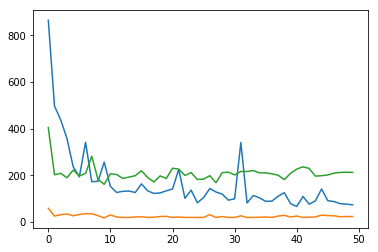

1


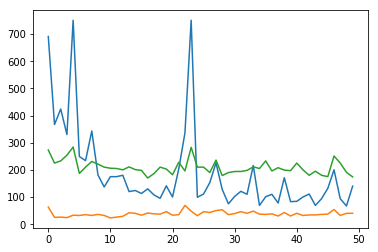

2


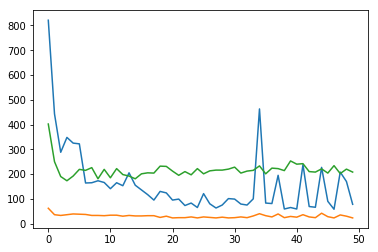

3


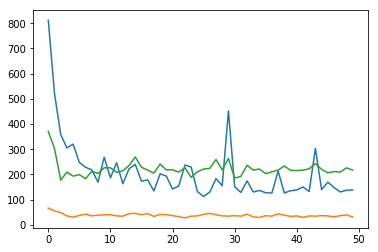

4


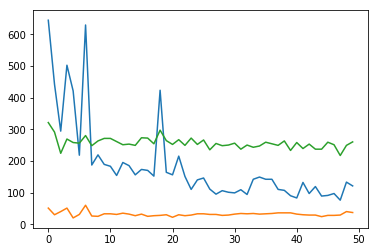

5


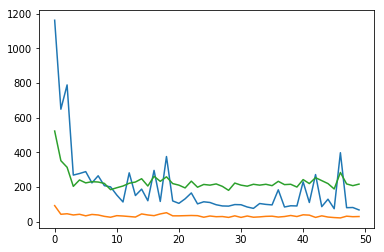

6


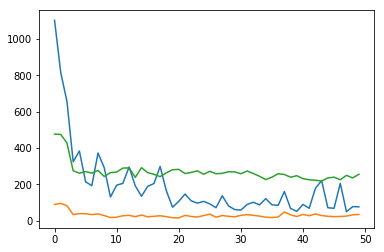

7


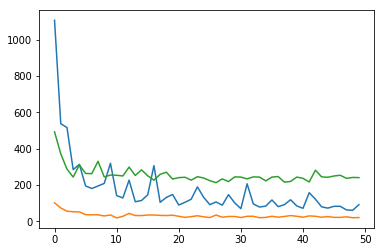

8


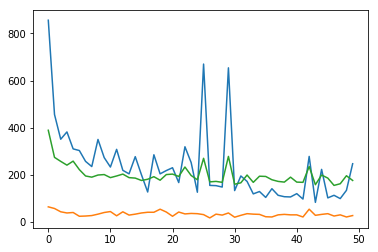

9


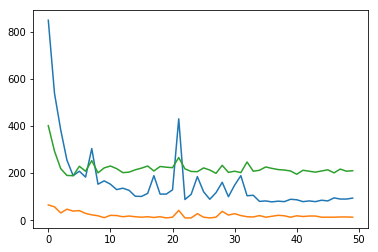

In [6]:
print(train_errors.shape)

for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(np.array(train_errors[i_rep, :]))
    plt.plot(np.array(validation_errors[i_rep, :]))
    plt.plot(np.array(test_errors[i_rep, :]))
    plt.show()

0


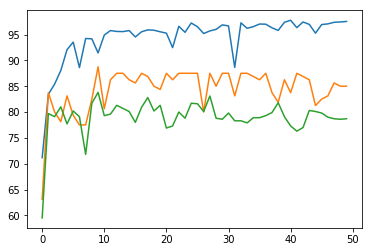

1


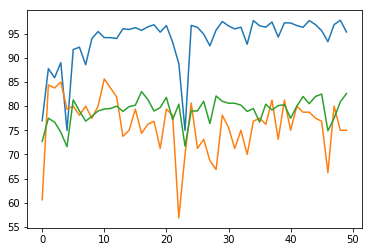

2


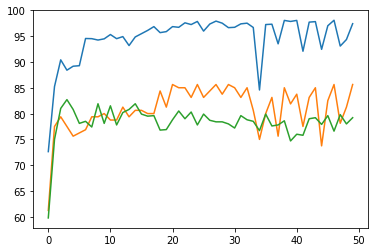

3


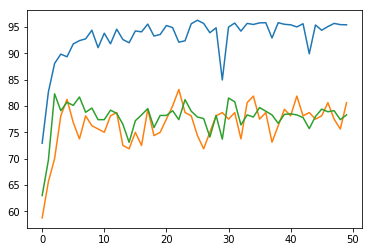

4


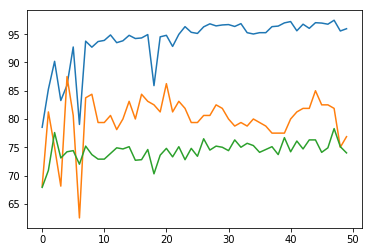

5


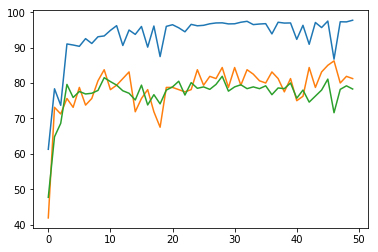

6


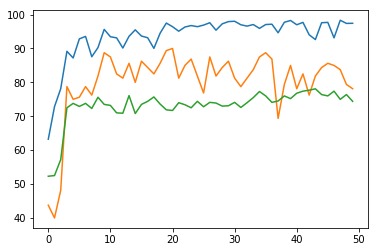

7


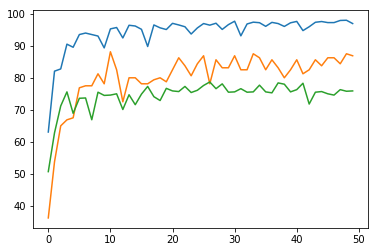

8


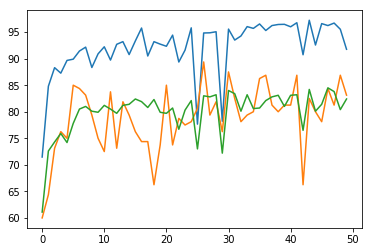

9


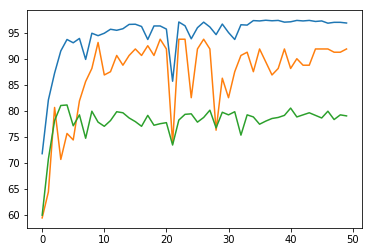

In [7]:
for i_rep in range(Nrep):
    print(i_rep)
    plt.plot(100*(Ntrain-np.array(train_errors[i_rep, :]))/Ntrain)
    plt.plot(100*(Nvalidation-np.array(validation_errors[i_rep, :]))/Nvalidation)
    plt.plot(100*(Ntest-np.array(test_errors[i_rep, :]))/Ntest)

    plt.show()

(50,)
Training accuracy 96.2%+-1.7075929641723633
Validation accuracy 82.4%+-4.852914810180664
Testing accuracy 78.3%+-2.7607243061065674


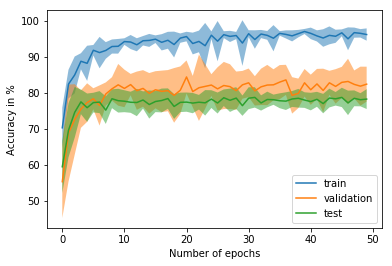

In [8]:
train_accuracy = 100*(Ntrain-np.array(train_errors))/Ntrain
val_accuracy = 100*(Nvalidation-np.array(validation_errors))/Nvalidation
test_accuracy = 100*(Ntest-np.array(test_errors))/Ntest

stddev_train_errors = np.std(train_accuracy, axis=0)
stddev_val_errors = np.std(val_accuracy, axis=0)
stddev_test_errors = np.std(test_accuracy, axis=0)

mean_train_errors = np.mean(train_accuracy, axis=0)
mean_val_errors = np.mean(val_accuracy, axis=0)
mean_test_errors = np.mean(test_accuracy, axis=0)

epoch = list(range(50))
print(stddev_train_errors.shape)

#plt.errorbar(epoch, mean_train_errors, stddev_train_errors)
#plt.errorbar(epoch, mean_val_errors, stddev_val_errors)
#plt.errorbar(epoch, mean_test_errors, stddev_test_errors)

plt.plot(epoch, mean_train_errors)
plt.plot(epoch, mean_val_errors)
plt.plot(epoch, mean_test_errors)
plt.fill_between(epoch, mean_train_errors+stddev_train_errors, mean_train_errors-stddev_train_errors, alpha=0.5)
plt.fill_between(epoch, mean_val_errors+stddev_val_errors, mean_val_errors-stddev_val_errors, alpha=0.5)
plt.fill_between(epoch, mean_test_errors+stddev_test_errors, mean_test_errors-stddev_test_errors, alpha=0.5)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy in %')
plt.legend(['train', 'validation', 'test'])

print("Training accuracy {:4.3g}%+-{}".format(mean_train_errors[-1], stddev_train_errors[-1]))
print("Validation accuracy {:4.3g}%+-{}".format(mean_val_errors[-1], stddev_val_errors[-1]))
print("Testing accuracy {:4.3g}%+-{}".format(mean_test_errors[-1], stddev_test_errors[-1]))